In [1]:
#imports

from itertools import product
import operator

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [37]:
#global vars
NUM_QUANTILES = 10

In [3]:
#get dataset
dataBunch = datasets.load_breast_cancer(return_X_y=False)
data_to_use = {"data": dataBunch.data[:,:10],
               "target": dataBunch.target,
               "feature_names": dataBunch.feature_names[:10],
               "feature_locs": {x:i for i,x in enumerate(dataBunch.feature_names[:10])}
              } #make it easy to change out data

In [154]:
dataCervicalCancer = pd.read_csv("data/cervical_cancer.csv")
target = dataCervicalCancer.Biopsy
dataCervicalCancer = dataCervicalCancer.drop(["Person", "Biopsy"],axis=1)
data_to_use = {"data": dataCervicalCancer.values,
               "target": target,
               "feature_names": dataCervicalCancer.columns,
               "feature_locs": {x:i for i,x in enumerate(dataCervicalCancer.columns)}   
              }

In [156]:
#build classifier to explain
classifier = RandomForestClassifier(n_estimators=100, max_depth=2)
classifier.fit(data_to_use["data"], data_to_use["target"])
predictions = classifier.predict(data_to_use["data"])
print accuracy_score(data_to_use["target"], predictions)

0.9358974358974359


In [168]:
#generate data structure for pairwise charts
feature_pairs = {key: {"map":None, "predicates":[]}\
                 for key in set([tuple(sorted(t)) for t in product(data_to_use["feature_names"], repeat=2)])}
feature_ranges = {}
for feature in data_to_use["feature_names"]:
    loc = data_to_use["feature_locs"][feature]
    if np.unique(data_to_use["data"][loc]).shape[0] < 10 or type(data_to_use["data"][loc][0]) is str:
        quantiles = np.unique(data_to_use["data"][loc])
    else:
        quantiles = np.around(np.unique(np.quantile(a=data_to_use["data"][loc], q=np.linspace(0, 1, NUM_QUANTILES))),4)
    feature_ranges[feature] = quantiles

def get_quantile_matrix(feat1, feat2):
    h = list(feature_ranges[feat1])*len(feature_ranges[feat2])
    v = [item for item in list(feature_ranges[feat1])\
         for i in range(len(feature_ranges[feat2]))]                        
    return h,v 
    
for key, value in feature_pairs.iteritems():
    print key
    h, v = get_quantile_matrix(key[0], key[1])
    print h
    print v
    value["map"]=np.array([{key[0]:x, key[1]:y}\
                           for x,y in zip(h,v)])\
    .reshape(len(feature_ranges[key[0]]), len(feature_ranges[key[1]]))

for model in classifier.estimators_:
    feature_ids = {i:{"number":x, "name":data_to_use["feature_names"][x]}\
                      for i,x in enumerate(list(model.tree_.feature)) if x>=0} #-2 means leaf node
    for node_position in [1,4]: #positions for left and right nodes at layer 2
        feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[node_position]["name"]]))
        #get the decision rules
        decision_func_dict = {
            "feature_name_1": feature_ids[0]["name"],
            "threshold_1": model.tree_.threshold[0],
            
            "operator_1": operator.le if node_position == 1 else operator.gt,
            
            "feature_name_2": feature_ids[node_position]["name"],
            "threshold_2": model.tree_.threshold[node_position],
            
            "operator_2": operator.le,
            
            "prob_le": model.tree_.value[node_position+1][0][1]/\
            (model.tree_.value[node_position+1][0][1] + model.tree_.value[node_position+1][0][0]),
            
            "prob_gt": model.tree_.value[node_position+2][0][1]/\
            (model.tree_.value[node_position+2][0][1] + model.tree_.value[node_position+2][0][0])
        }
        #build the predictive function used in the decision tree
        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
            if decision_func_dict["operator_1"](\
                                                data_case[decision_func_dict["feature_name_1"]],\
                                                decision_func_dict["threshold_1"]\
                                               ):
                if decision_func_dict["operator_2"](\
                                                    data_case[decision_func_dict["feature_name_2"]],\
                                                    decision_func_dict["threshold_2"]\
                                                   ):
                    return decision_func_dict["prob_le"]
                else:
                    return decision_func_dict["prob_gt"]
            else:
                return 0.

        feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)

('First sexual intercourse', 'Smokes (packs/year)')
[0.0, 1.0, 17.0, 34.0, 0.0, 1.0, 17.0, 34.0, 0.0, 1.0, 17.0, 34.0, 0.0, 1.0, 17.0, 34.0, 0.0, 1.0, 17.0, 34.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 17.0, 17.0, 17.0, 17.0, 34.0, 34.0, 34.0, 34.0, 34.0]
('Num of pregnancies', 'Smokes (years)')
[0.0, 3.0, 4.0, 5.0, 16.0, 37.0, 52.0, 0.0, 3.0, 4.0, 5.0, 16.0, 37.0, 52.0, 0.0, 3.0, 4.0, 5.0, 16.0, 37.0, 52.0, 0.0, 3.0, 4.0, 5.0, 16.0, 37.0, 52.0, 0.0, 3.0, 4.0, 5.0, 16.0, 37.0, 52.0, 0.0, 3.0, 4.0, 5.0, 16.0, 37.0, 52.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]
('Number of sexual partners', 'Number of sexual partners')
[0.0, 1.0, 14.0, 15.0, 0.0, 1.0, 14.0, 15.0, 0.0, 1.0, 14.0, 15.0, 0.0, 1.0, 14.0, 15.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15

KeyError: 4

In [68]:
#now calculate output array for each feature pair
for key, value in feature_pairs.iteritems():
    arrs = []
    for predicate in value["predicates"]:
        f = np.vectorize(predicate)
        arrs.append(f(value["map"]))
    if len(arrs) > 0:
        #details of vote aggreggation method for random forest
        #https://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
        value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)
    else:
        value["output"] = None

In [76]:
vis_df_dict = {}
for key, value in feature_ranges.iteritems():
    vis_df_dict[key+"_V"] = value["V"]
    vis_df_dict[key+"_H"] = value["H"]
for key, value in feature_pairs.iteritems():
    x = key[0]
    y = key[1]
    '''
    if x == y:
        pass
    else:
        if x+"_H" not in vis_df_dict:
            vis_df_dict[x+"_H"] = [p[x] for p in list(value["map"].ravel())]
        if y+"_V" not in vis_df_dict:
            vis_df_dict[y+"_V"] = [p[y] for p in list(value["map"].ravel())]
    '''
    vis_df_dict["pair: " + x + "," + y] = list(value["output"].ravel()) if value["output"] is not None else None

In [123]:
chart_data = pd.DataFrame(vis_df_dict)
offset = 0
for col in [x for x in chart_data.columns if x.startswith("pair: ")]:
    srs = chart_data.loc[:,col]
    if srs.apply(lambda x: x==0.).all():
        print "all zeroes: " + col
        chart_data[col] = None
    elif srs.std()/srs.mean() < 0.1:
        print "low std: " + col
        offset += srs.mean()
        chart_data[col] = None
    elif srs.max() < 1.:
        print "low impact: " + col
        chart_data[col] = None
        offset += srs.mean()
chart_data["dummy_null"] = None
print offset

low std: pair: mean area,mean area
low std: pair: mean area,mean concave points
low impact: pair: mean area,mean radius
all zeroes: pair: mean area,mean smoothness
all zeroes: pair: mean area,mean texture
low impact: pair: mean compactness,mean concave points
low impact: pair: mean compactness,mean radius
low impact: pair: mean compactness,mean texture
low impact: pair: mean concave points,mean concave points
low impact: pair: mean concave points,mean fractal dimension
low impact: pair: mean concave points,mean smoothness
low impact: pair: mean concavity,mean smoothness
low impact: pair: mean concavity,mean texture
low impact: pair: mean perimeter,mean smoothness
low impact: pair: mean perimeter,mean symmetry
11.6333913845


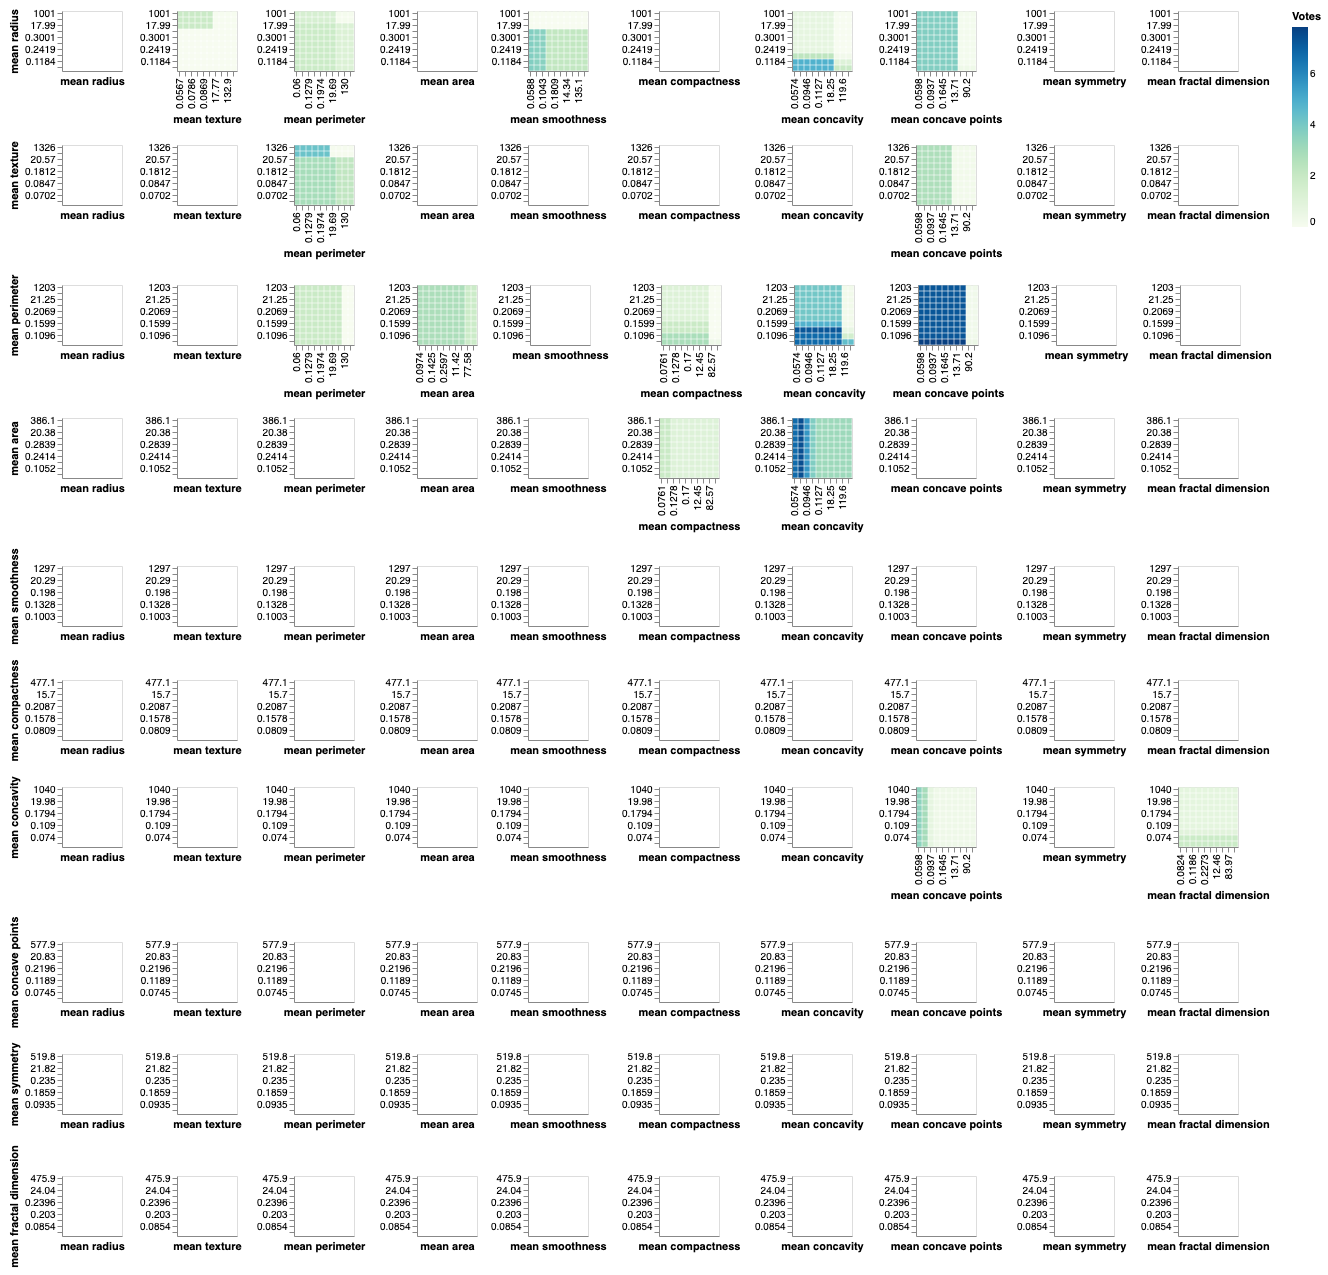

In [137]:
base = alt.Chart().properties(
    width=60,
    height=60
)

chart = alt.vconcat(data=chart_data)
for irow, y_feature in enumerate(data_to_use["feature_names"]):
    row = alt.hconcat()
    for icol, x_feature in enumerate(data_to_use["feature_names"]):
        x_encoding = alt.X(field=x_feature+"_H", type="ordinal", sort="ascending",\
                           axis=alt.Axis(title=x_feature))
        y_encoding = alt.Y(field=y_feature+"_V", type="ordinal", sort="descending",\
                           axis=alt.Axis(title=y_feature if icol==0 else ""))
        temp_sort = sorted([x_feature, y_feature])
        if chart_data.loc[:,"pair: " + temp_sort[0] + "," + temp_sort[1]].iloc[0] is not None\
        and irow<=icol:
            color_encoding = alt.Color(field= "pair: " + temp_sort[0] + "," + temp_sort[1]\
            , type="quantitative", scale=alt.Scale(scheme="greenblue"), legend=alt.Legend(title="Votes"))
        else:
            color_encoding=alt.Color(field="dummy_null", type="quantitative")
        row |= base.mark_rect().encode(x=x_encoding, y=y_encoding, color=color_encoding)
    chart &= row
chart